In [1]:
import numpy as np
from einops import rearrange, repeat
from analyze_subject import *
from my_utils import *
from scipy.stats import differential_entropy
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.mixture import GaussianMixture
np.random.seed(0)

--------------------------------

# Introduction

### Which classifier to use?

In [2]:
# create obviously separable data
bl = np.repeat(np.arange(40), 4).reshape((40, 4))
de = np.array([trial - trial_baseline for trial, trial_baseline in zip(np.zeros((40, 60, 32, 4)), bl)])

clf1 = MLPClassifier(hidden_layer_sizes=(256,256,128,64))
clf2 = MLPClassifier(hidden_layer_sizes=(256,256,128,64), n_iter_no_change=2000, max_iter=2000)

rng = np.random.default_rng(seed=0)
dat = rng.permutation(de, axis=1)
dat = rearrange(dat, 'trials (folds chunks) channels bands -> trials folds chunks (channels bands)', folds=5)
X_train = rearrange(dat[:, 1:], 'trials folds chunks ... -> (trials folds chunks) ...')
X_test = rearrange(dat[:, 0], 'trials chunks ... -> (trials chunks) ...')

clf1.fit(X_train, np.repeat(np.arange(40), 48))
clf2.fit(X_train, np.repeat(np.arange(40), 48))
clf1.score(X_test, np.repeat(np.arange(40), 12)), clf2.score(X_test, np.repeat(np.arange(40), 12))

/home/mca/anaconda3/envs/bci/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


(0.05, 0.975)

# Analysis of one subject

In [2]:
SUBJ_ID = 15

# For a description of DEAP, see the Methods Section of the accompanying paper
data, data_baseline, labels_valence = get_single_subject_data(subj_id=SUBJ_ID)

# get_single_subject_data() returns processed EEG data in the shape of 
# (trials, chunks, channels, bands, datapoints).
# - Per subject, there are 40 trials
# - Each trial is windowed into 60 chunks of 1s in case of the main data. 
#   The baseline is windowed into 3 chunks of 1s.
# - The EEG data was recorded with 32 channels
# - We decomposed it into 4 bands using a 3rd order butterworth filter. 
#   We also appended a fifth band which contains the original (not-decomposed) data.
# - Each chunk contains windows of 128 datapoints
# We drop the not-decomposed data.
data, data_baseline = data[..., :4, :], data_baseline[..., :4, :]

# To get the feature vectors, we compute the differential entropy (DE)
# along the windows.
de_main = differential_entropy(data, axis=-1)
de_base = differential_entropy(data_baseline, axis=-1)

## Trial idiosyncratic patterns

In [3]:
np.mean(predict_trial_labels(de_main))

0.605

In [3]:
# Can we find the manifolds using unsupervised learning?
feat = rearrange(de_main[:,20:], 'trials chunks channels bands -> (trials chunks) (channels bands)')
#feat = np.random.rand(*(feat.shape))

pred_class = GaussianMixture(n_components=40, covariance_type='tied').fit_predict(feat)
#pred_class = np.random.choice(np.arange(40), size=pred_class.shape)

trials = np.arange(feat.shape[0]).reshape((40,40))
l = []
for trial in trials:
    #print(np.unique(pred_class[trial], return_counts=True))
    l.append(np.bincount(pred_class[trial], minlength = 40))

l = np.array(l).T# (labels, trials)

Text(0.5, 1.0, "Correspondance between\npredicted 'trials' and real trials")

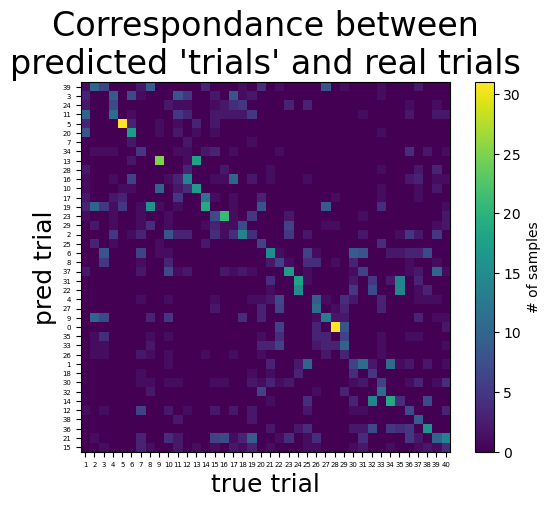

In [96]:
label_to_best_trial_fit = np.argmax(l, axis=1) # m[label] -> trial
labels_sorted = np.argsort(label_to_best_trial_fit) #  -> label
plt.imshow(l[labels_sorted], vmin=0)
plt.xticks(np.arange(40), np.arange(1,41), fontsize = 5)
plt.yticks(np.arange(40), labels_sorted, fontsize = 5)
plt.colorbar().set_label('# of samples')
plt.xlabel('true trial', fontsize=18)
plt.ylabel('pred trial', fontsize=18)
plt.title("Correspondance between\npredicted 'trials' and real trials", fontsize=24)

In [6]:
# go through predicted labels and see what percentage pertains to one trial
s = np.flip(np.sort(l, axis=-1), axis=-1) # We loose the trial mapping here!
ss = np.sum(s, axis=-1)
print(np.mean(s[:,0]/ss))
print(np.mean(np.sum(s[:,:3], axis=-1)/ss))

0.3419711521018819
0.6762674475501125


In [7]:
predict_trial_labels_of_test_set_using_folds(de_main, de_base, classifier=MLPClassifier(hidden_layer_sizes=(256,256,128,64)))

/home/mca/anaconda3/envs/bci/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


array([0.16666667, 0.175     , 0.125     , 0.18333333, 0.19166667])

In [8]:
s = predict_valence_labels(de_main, labels_valence)
print(f'Mean accuracy for paradigm 1: {np.mean(s["paradigm 1"])}')
print(f'Mean accuracy for paradigm 2: {np.mean(s["paradigm 2"])}')

Mean accuracy for paradigm 1: 0.8383333333333333
Mean accuracy for paradigm 2: 0.7450000000000001


In [9]:
lbl = np.random.permutation(labels_valence)
s = predict_valence_labels(de_main, lbl)
print(f'Mean accuracy for paradigm 1: {np.mean(s["paradigm 1"])}')
print(f'Mean accuracy for paradigm 2: {np.mean(s["paradigm 2"])}')

Mean accuracy for paradigm 1: 0.70625
Mean accuracy for paradigm 2: 0.47041666666666665


## Baselines

In [13]:
# Subtracting the baseline
# This is not well described in (https://ceur-ws.org/Vol-3368/paper4.pdf).
# We also average over all channels to get the shape mentioned there.
de_base_mean = np.mean(de_base, axis=(1,2))
de = np.array([trial - trial_baseline for trial, trial_baseline in zip(de_main, de_base_mean)])

In [14]:
np.mean(predict_trial_labels(de))

0.8170833333333333

In [15]:
gm = MultivariateGaussModel()

# We have to reduce the dimensionality of the data to estimate
# a proper covariance matrix
# Therefore we only use the last two bands and a list of channels
# which were deemed relevant by https://link.springer.com/article/10.1007/s12559-023-10171-2
rel_channel_ids = np.array([1, 2, 3, 4, 8, 12, 16, 18, 19, 22, 27, 29, 30, 32])-1
selected_features = np.ix_(rel_channel_ids, [1,2])

s1 = predict_trial_labels(de_main[...,*selected_features], classifier=gm)
s2 = predict_trial_labels(de[...,*selected_features], classifier=gm)

print(f'Acc for non-baseline-removed data: {np.mean(s1)}')
print(f'Acc for baseline-removed data: {np.mean(s2)}')

Acc for non-baseline-removed data: 0.36291666666666667
Acc for baseline-removed data: 0.5033333333333333


In [16]:
# Gather baselines of all subjects
baselines = np.zeros((34, 40, 4))

# First baseline is 0
baselines[0][:] = np.zeros((40, 4))

# Last baseline is made up
baselines[33][:] = np.repeat(np.arange(40)*4, 4).reshape((40, 4))

for subj_id in range(1,33):
    _, data_baseline, _ = get_single_subject_data(subj_id=subj_id)
    data_baseline = data_baseline[..., :4, :]
    de_base = differential_entropy(data_baseline, axis=-1)
    de_base_mean = np.mean(de_base, axis=(1,2))
    baselines[subj_id][:] = de_base_mean

In [ ]:
bl_matrix = np.full((34, 32, ), -1, dtype=float) # baselines, subjects

for b_id, baseline in enumerate(baselines):
    print(b_id)
    for subj_id in range(1,33):
        dat, _, _ = get_single_subject_data(subj_id=subj_id)
        dat = dat[..., :4, :]
        dat = differential_entropy(dat, axis=-1)
        dat = np.array([trial - trial_baseline for trial, trial_baseline in zip(dat, baseline)])
        
        # Get acuracy for trial prediction for dat
        s = np.mean(predict_trial_labels(dat))
        
        bl_matrix[b_id, subj_id-1] = s

np.save('bl_matrix', bl_matrix)

In [29]:
np.argsort(bl_matrix[0])

array([15, 21,  3, 14, 10,  4,  8, 22, 23,  7,  6, 24, 17, 11,  1, 27, 18,
       25,  2,  0, 12, 13,  5,  9, 16, 28, 31, 30, 29, 20, 26, 19])

Text(0.5, 1.0, 'Difference in accuracy:\nSubtracted baseline vs. Subject')

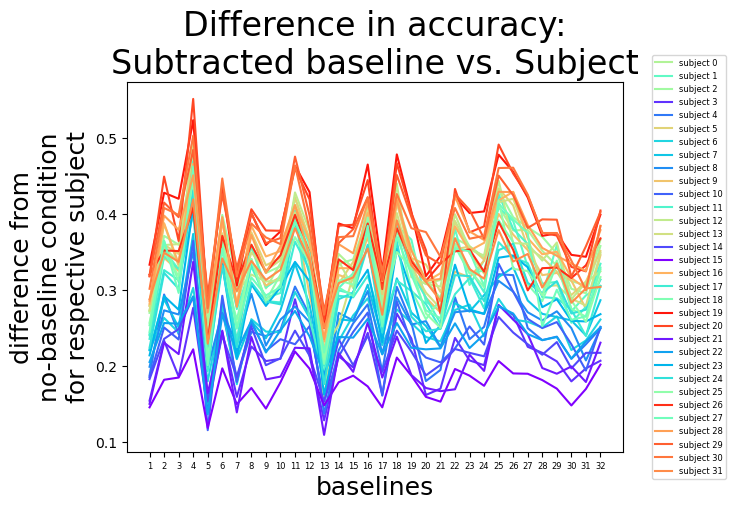

In [91]:
bl_matrix = np.load('bl_matrix.npy')

# We want difference from baseline (in row 0) for each subject
bl_matrix -= bl_matrix[0]
assert not bl_matrix[0].any()
bl_matrix = bl_matrix[1:33]


# x-axis: baselines
cmap = matplotlib.colormaps['rainbow']
#plt.scatter(np.repeat(np.arange(32), 32), bl_matrix.flatten(), c=cmap(np.tile(np.arange(32), 32)/32))
color_map = np.argsort(np.argsort(bl_matrix[0]))
for i, subject in enumerate(bl_matrix.T):
    plt.plot(subject, c=cmap(color_map[i]/32), label=f"subject {i}" )
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), prop={'size': 6})
#for i, subject in enumerate(bl_matrix.T):
#    plt.plot(subject, color = cmap[i])
plt.xticks(np.arange(32), np.arange(1,33), fontsize = 6)
plt.xlabel('baselines', fontsize=18)
plt.ylabel('difference from\nno-baseline condition\nfor respective subject', fontsize=18)
plt.title('Difference in accuracy:\nSubtracted baseline vs. Subject', fontsize = 24)

Text(0, 0.5, 'Baseline of subject')

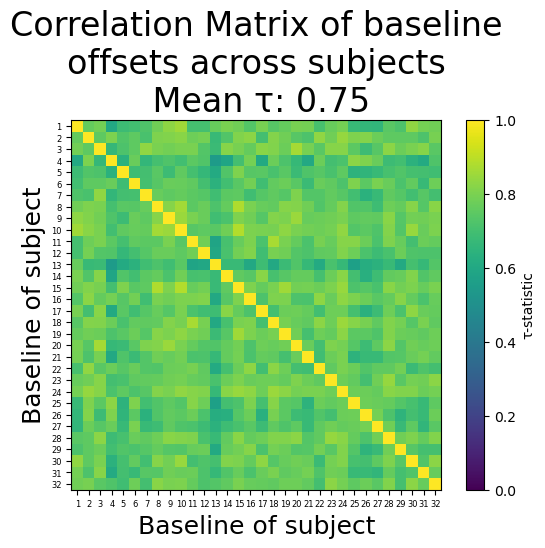

In [95]:
bl_corr = np.zeros((32, 32))
for i in range(32):
    for j in range(i, 32):
        bl_corr[i,j] = stats.kendalltau(bl_matrix[i], bl_matrix[j])[0]

plt.imshow(bl_corr + bl_corr.T - np.diag(np.diag(bl_corr)), vmin=0.0, vmax=1.0)
plt.colorbar().set_label('τ-statistic')
plt.xticks(np.arange(32), np.arange(1,33), fontsize = 6)
plt.yticks(np.arange(32), np.arange(1,33), fontsize = 6)
plt.title(f"Correlation Matrix of baseline\noffsets across subjects\n Mean τ: {np.mean(bl_corr[np.triu_indices(32,1)]):.2f}", fontsize=24)
plt.xlabel("Baseline of subject", fontsize = 18)
plt.ylabel("Baseline of subject", fontsize = 18)

In [19]:
bl_matrix = np.load('bl_matrix.npy')
np.mean(bl_matrix[-1])

0.9999869791666667

In [20]:
print("Without baseline removal: ", np.mean(predict_valence_labels(de_main, labels_valence)["paradigm 2"]))
print("With baseline removal: ", np.mean(predict_valence_labels(de, labels_valence)["paradigm 2"]))

Without baseline removal:  0.7295833333333335
With baseline removal:  0.6670833333333334


# Analysis over all subjects

In [ ]:
acc_valence_labels = np.full((32, 2, 5), -1, dtype=float)
acc_shuffled_valence_labels = np.full((32, 2, 5), -1, dtype=float)
acc_trial_labels = np.full((32, 5), -1, dtype=float)
acc_baseline_trial_labels = np.full((32, 5), -1, dtype=float)

for i, subj_id in enumerate(range(1, 33)):
    print(subj_id)
    data, data_baseline, labels_valence = get_single_subject_data(subj_id=subj_id)
    data, data_baseline = data[..., :4, :], data_baseline[..., :4, :]
    de_main = differential_entropy(data, axis=-1)
    de_base = differential_entropy(data_baseline, axis=-1)
    results = analyze_subject(de_main, de_base, labels_valence)
    acc_valence_labels[i][:] = results['acc predicting valence labels']['paradigm 1'], results['acc predicting valence labels']['paradigm 2']
    acc_shuffled_valence_labels[i][:] = results['acc predicting shuffled valence labels']['paradigm 1'], results['acc predicting shuffled valence labels']['paradigm 2']
    acc_trial_labels[i][:] = results['acc predicting trial labels']
    acc_baseline_trial_labels[i][:] = results['acc predicting baseline trial labels']

np.savez('results.npz', 
            acc_valence_labels=acc_valence_labels, 
            acc_shuffled_valence_labels=acc_shuffled_valence_labels, 
            acc_trial_labels=acc_trial_labels, 
            acc_baseline_trial_labels=acc_baseline_trial_labels)

In [116]:
# load data generated in the above cell
f = np.load('results.npz')
acc_valence_labels = f['acc_valence_labels']
acc_shuffled_valence_labels = f['acc_shuffled_valence_labels']
acc_trial_labels = f['acc_trial_labels']
acc_baseline_trial_labels = f['acc_baseline_trial_labels']

In [188]:
def plot_subject_wise(dat, baseline, ax, title, legend=False):
    # Expects dat of shape (subjects, scores)
    ax.scatter(np.repeat(np.arange(dat.shape[0]), dat.shape[1]), dat.flatten(), marker='.', s=2, color='black', label='accuracy of single folds')
    ax.scatter(np.arange(dat.shape[0]), np.mean(dat, axis=1), marker='_', color='orange', label='mean accuracy of folds')
    ax.axhline(baseline, linestyle='--', color='red', alpha=0.3, label='uniform guessing accuracy')
    ax.axhline(np.mean(dat), color='red', alpha=0.3, label='mean accuracy overall')
    ax.set_xticks(np.arange(32), np.arange(1,33), fontsize=6)
    ax.set_xlabel('subject', fontsize=18)
    ax.set_ylabel('accuracy', fontsize=18)
    if legend:
        ax.legend(prop={'size': 8})
    ax.set_title(title, fontsize=20)
    #l, h = stats.t.interval(0.95, dat.shape[0]-1, loc=np.mean(dat), scale=stats.sem(np.mean(dat, axis=-1)))
    #ax.axvspan(-1, 33, l, h, facecolor='red', alpha=0.05)
    #ax.margins(x=0)

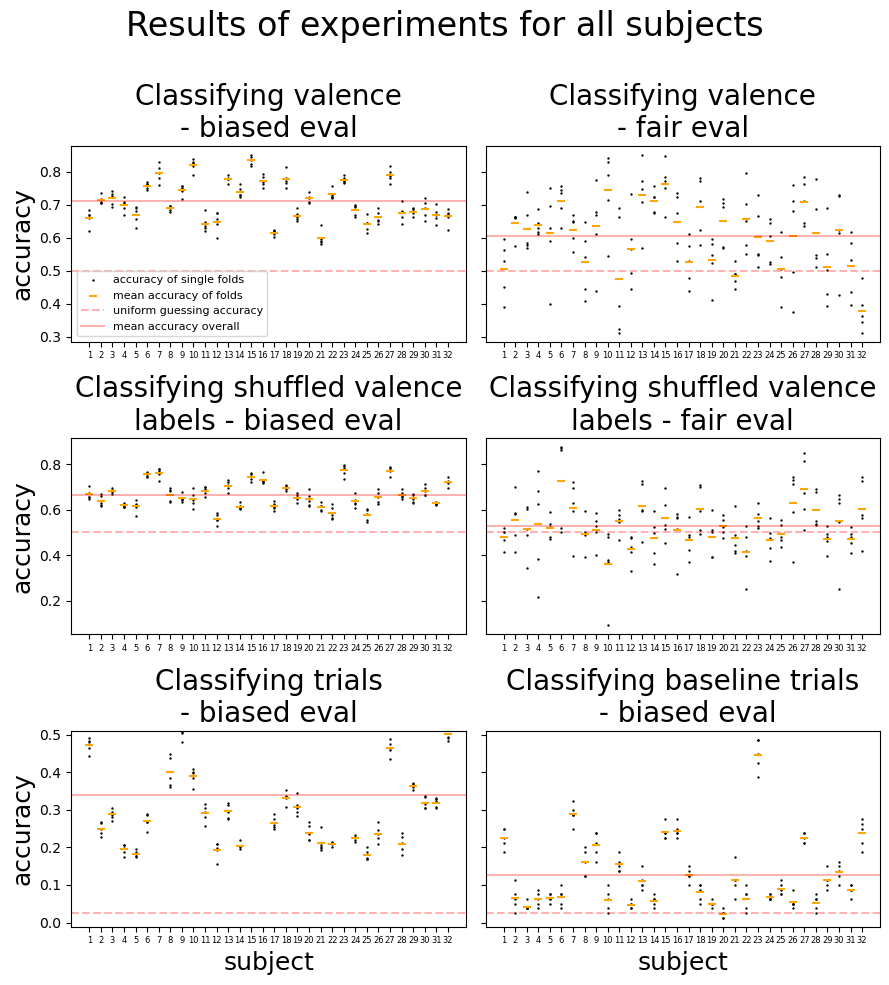

In [199]:
fig, axs = plt.subplots(3,2, figsize=(9,10))
plot_subject_wise(acc_valence_labels[:,0,:], 0.5, axs[0,0], 'Classifying valence\n- biased eval', legend=True)
plot_subject_wise(acc_valence_labels[:,1,:], 0.5, axs[0,1], 'Classifying valence\n- fair eval')
axs[0,0].sharey(axs[0,1])
plot_subject_wise(acc_shuffled_valence_labels[:,0,:], 0.5, axs[1,0], 'Classifying shuffled valence\nlabels - biased eval')
plot_subject_wise(acc_shuffled_valence_labels[:,1,:], 0.5, axs[1,1], 'Classifying shuffled valence\nlabels - fair eval')
axs[1,0].sharey(axs[1,1])
plot_subject_wise(acc_trial_labels, 0.025, axs[2,0], 'Classifying trials\n- biased eval')
plot_subject_wise(acc_baseline_trial_labels, 0.025, axs[2,1], 'Classifying baseline trials\n - biased eval')
axs[2,0].sharey(axs[2,1])
for ax in axs[:,1]:
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_ylabel(None)
for ax in axs.flatten()[:4]:
    ax.set_xlabel(None)


fig.suptitle('Results of experiments for all subjects', fontsize=24)
fig.tight_layout(rect=[0, 0, 1, 0.97])

# Investigation of a more elaborate model

In [1]:
from torcheeg.model_selection import KFoldGroupbyTrial
from trialwiseKFold import trialwiseKFold
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torcheeg.datasets import DEAPDataset
from torcheeg import transforms
from torcheeg.datasets.constants import DEAP_CHANNEL_LOCATION_DICT
from torcheeg.models import CCNN
from torcheeg.trainers import ClassifierTrainer
import pytorch_lightning as pl

In [ ]:
# Load DEAP dataset
dataset = DEAPDataset(
    io_path='.torcheeg/datasets_1726117455312_HNcDq',
    root_path='./data/DEAP/data_preprocessed_python',
    offline_transform=transforms.Compose([
        transforms.BandDifferentialEntropy(apply_to_baseline=True),
        transforms.ToGrid(DEAP_CHANNEL_LOCATION_DICT, apply_to_baseline=True)
    ]),
    online_transform=transforms.Compose(
        [#transforms.BaselineRemoval(),
         transforms.ToTensor()]),
    label_transform=transforms.Compose([
        transforms.Select('valence'),
        transforms.Binary(5.0),
    ]),
    num_worker=8)

In [2]:
data, _, labels_valence = get_single_trial_data(trial_id=0)
data = data[..., :4, :]
de_main = differential_entropy(data, axis=-1)

np.mean(predict_trial_labels(de_main))

0.9989583333333334

In [ ]:
#k_fold = KFoldGroupbyTrial(n_splits=5, shuffle=True)
k_fold = trialwiseKFold(shuffle=True)

In [ ]:
# Training/Eval loop
for i, (train_dataset, val_dataset) in enumerate(k_fold.split(dataset)):
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    model = CCNN(num_classes=2, in_channels=4, grid_size=(9, 9))

    trainer = ClassifierTrainer(model=model,
                                num_classes=2,
                                lr=1e-4,
                                weight_decay=1e-4,
                                accelerator="gpu")
    trainer.fit(train_loader,
                val_loader,
                max_epochs=10,
                default_root_dir=f'./examples_seed_ccnn/model/{i}',
                callbacks=[pl.callbacks.ModelCheckpoint(save_last=True)],
                enable_progress_bar=True,
                enable_model_summary=True,
                limit_val_batches=0.0)
    score = trainer.test(val_loader,
                         enable_progress_bar=True,
                         enable_model_summary=True)[0]
    print(f'Fold {i} test accuracy: {score["test_accuracy"]:.4f}')

# Apendix A

In [2]:
SUBJ_ID = 15
data, data_baseline, labels_valence = get_single_subject_data(subj_id=SUBJ_ID)
data, data_baseline = data[..., :4, :], data_baseline[..., :4, :]
de_main = differential_entropy(data, axis=-1)
de_base = differential_entropy(data_baseline, axis=-1)

Text(0.5, 1.0, 'Accuracy in label prediction\nvs. position of chunks (subj. 15)')

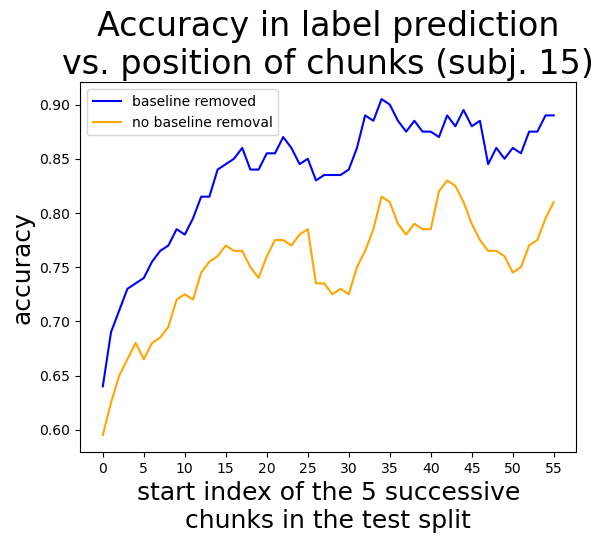

In [201]:
compare_against = repeat(np.arange(5), 'a -> b a', b=56)
compare_against += repeat(np.arange(56), 'a -> a b', b=5)

scores = []

for c_a in compare_against:
    train_data = de_main[:, np.setdiff1d(np.arange(60), c_a), ...]
    test_data = de_main[:, c_a, ...]
    scores.append(compare_on_fixed_train_test_using_folds(train_data, test_data, labels_valence))

scores = np.mean(np.array(scores), axis=-1).T

plt.plot(scores[0], color='blue', label='baseline removed')
plt.plot(scores[1], color='orange', label='no baseline removal')
plt.legend()
plt.xticks(np.arange(56, step=5), np.arange(56, step=5), fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('accuracy', fontsize=18)
plt.xlabel('start index of the 5 successive\nchunks in the test split', fontsize=18)
plt.title('Accuracy in label prediction\nvs. position of chunks (subj. 15)', fontsize=24)